In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as T
import glob
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
imagePath = "C:/Users/lskus/Downloads/images/images"
imagePaths = []
for data_path in glob.glob(imagePath + '/*'):
    imagePaths.append(data_path)

In [3]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, imagePaths, transforms):
        # init method takes list of image paths, ground truth masks, and transformations as input
        self.imagePaths = imagePaths
        self.transforms = transforms
    
    def __len__(self):
        # total number of image paths in dataset
        return len(self.imagePaths)
    
    def __getitem__(self,idx):
        # returns sample from dataset
        imagePath = self.imagePaths[idx]
        
        #image = cv2.imdecode(np.fromfile(imagePath, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
        image = Image.open(imagePath)
        
        if self.transforms is not None:
            image = self.transforms(image)

        return image

transforms = T.Compose([T.Resize((256,256)),
                        T.ToTensor()])
dataset = Dataset(imagePaths = imagePaths,
                  transforms = transforms)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

training = torch.utils.data.DataLoader(dataset = train_dataset,
                                     batch_size = 128,
                                     shuffle = True,
                                     pin_memory = True)

testing = torch.utils.data.DataLoader(dataset = test_dataset,
                                     batch_size = 128,
                                     shuffle = True,
                                     pin_memory = True)

latent_dims = 10000

In [4]:
test_dataset.indices

[19260,
 3355,
 49230,
 27606,
 38031,
 13590,
 42638,
 9472,
 34754,
 34566,
 5177,
 5938,
 379,
 28472,
 33394,
 22902,
 43574,
 14785,
 37101,
 874,
 39636,
 26003,
 22177,
 2251,
 9900,
 47680,
 43526,
 23324,
 28448,
 44665,
 8823,
 17539,
 34375,
 39563,
 44844,
 38075,
 25076,
 49411,
 40204,
 40903,
 21103,
 5727,
 48568,
 41897,
 38243,
 33301,
 22334,
 9931,
 7320,
 48031,
 11109,
 35563,
 5051,
 37931,
 41304,
 21004,
 45274,
 34948,
 13031,
 16563,
 7258,
 13811,
 43457,
 45768,
 4551,
 2158,
 21128,
 22519,
 26661,
 5090,
 14628,
 39483,
 25788,
 13987,
 29866,
 21996,
 43872,
 21466,
 37082,
 33137,
 24514,
 15264,
 39566,
 38280,
 12033,
 32954,
 27058,
 33895,
 14652,
 20319,
 32183,
 10624,
 20543,
 15352,
 11438,
 34698,
 3170,
 13862,
 38188,
 35143,
 38171,
 10670,
 2127,
 12209,
 20619,
 5406,
 47440,
 21113,
 34925,
 34517,
 40177,
 5626,
 8494,
 14549,
 37809,
 40852,
 25057,
 8837,
 35279,
 24962,
 27392,
 23818,
 8858,
 39358,
 15610,
 33576,
 17968,
 36622,
 2

In [5]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(256*256*3, 1024)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)
        self.linear4 = nn.Linear(1024,512)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear4(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(1024, 256*256*3)
        self.linear3 = nn.Linear(512,1024)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear3(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 3, 256, 256))

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [8]:
# log cosh loss function from https://openreview.net/pdf?id=rkglvsC9Ym

def train(autoencoder, data, a=10, epochs=200):
    opt = torch.optim.Adam(autoencoder.parameters(), lr = 1e-4)
    trainLosses=[]
    count = 1
    for epoch in range(epochs):
        runningLoss = 0
        for (x) in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((1/a)*torch.log(torch.cosh(a*(x - x_hat)))).sum() + autoencoder.encoder.kl
            runningLoss = runningLoss + loss.item()
            loss.backward()
            opt.step()
        trainLoss = runningLoss/len(data)
        trainLosses.append(trainLoss)
        print(trainLoss)
        print("epoch", count, "finished!")
        count = count + 1
    return autoencoder, trainLosses

In [9]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae, trainLosses = train(vae, training)

3554583.8203125
epoch 1 finished!
2865012.8813920454
epoch 2 finished!
2510375.6171875
epoch 3 finished!
2146866.6896306816
epoch 4 finished!
1815600.0374644885
epoch 5 finished!
1570798.6280184658
epoch 6 finished!
1414095.9073153408
epoch 7 finished!
1320152.7883522727
epoch 8 finished!
1261755.5582386365
epoch 9 finished!
1223430.0543323865
epoch 10 finished!
1197989.453125
epoch 11 finished!
1181132.0846946023
epoch 12 finished!
1167232.1489701704
epoch 13 finished!
1155338.2965198865
epoch 14 finished!
1143751.1040482954
epoch 15 finished!
1134161.6512784092
epoch 16 finished!
1125880.2262073865
epoch 17 finished!
1116414.6235795454
epoch 18 finished!
1110124.6811079546
epoch 19 finished!
1101863.5404829546
epoch 20 finished!
1094294.0
epoch 21 finished!
1088285.7267400569
epoch 22 finished!
1081714.7009943181
epoch 23 finished!
1074614.1157670454
epoch 24 finished!
1071269.5616122158
epoch 25 finished!
1064811.4357244319
epoch 26 finished!
1058548.8860085227
epoch 27 finished!
10

830938.1038707386
epoch 220 finished!
830208.2061434659
epoch 221 finished!
829316.1012073864
epoch 222 finished!
829059.0519353693
epoch 223 finished!
828425.0490056818
epoch 224 finished!
827697.6251775568
epoch 225 finished!
827097.6569602273
epoch 226 finished!
826911.4708806818
epoch 227 finished!
826117.1924715909
epoch 228 finished!
825501.9147727273
epoch 229 finished!
824940.0295632102
epoch 230 finished!
824614.1780894886
epoch 231 finished!
824044.6988636364
epoch 232 finished!
823190.0719105114
epoch 233 finished!
822464.6980646307
epoch 234 finished!
822505.2083629261
epoch 235 finished!
821648.0369318182
epoch 236 finished!
820755.5829190341
epoch 237 finished!
820234.9858842329
epoch 238 finished!
819715.5772372159
epoch 239 finished!
819716.8473899148
epoch 240 finished!
818716.4003018466
epoch 241 finished!
818382.5708451704
epoch 242 finished!
817816.8223544034
epoch 243 finished!
816924.1775568182
epoch 244 finished!
816563.5546875
epoch 245 finished!
815911.69282670

In [10]:
torch.save(vae, "C:/Users/lskus/OneDrive/Documents/Current Assignments/CS585/vae_300epochs_10000latent_10a_Conv_2layers.pth")
torch.cuda.empty_cache()

In [ ]:
vae = torch.load("C:/Users/lskus/OneDrive/Documents/Current Assignments/CS585/vae_20epochs.pth")
vae.eval()
vae.state_dict()

In [ ]:
def test(autoencoder, data):
    outputs = []
    for (x) in data:
        x = x.to(device)
        reconstructed = autoencoder(x)
        reconstructed = reconstructed.to(device)
        outputs.append(reconstructed)
        
    return outputs

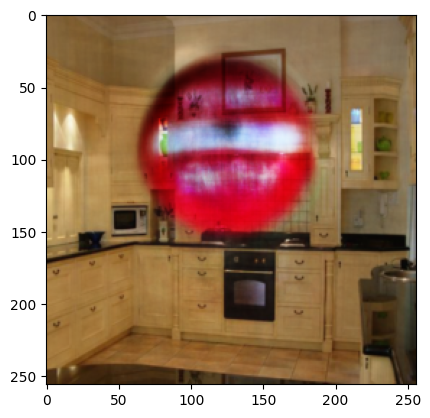

In [26]:
testInput1 = "C:/Users/lskus/Downloads/images/images/39483.jpg"
#test1 = cv2.imdecode(np.fromfile(testInput1, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
test1 = Image.open(testInput1)
img_tensor = transforms(test1).to('cuda').unsqueeze(0)
output = vae(img_tensor)
output = output.squeeze()
output = output.permute((1,2,0))
output = output.detach().cpu()
plt.imshow(output)

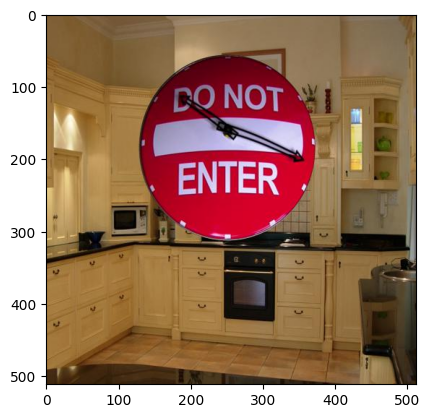

In [27]:
plt.imshow(test1)

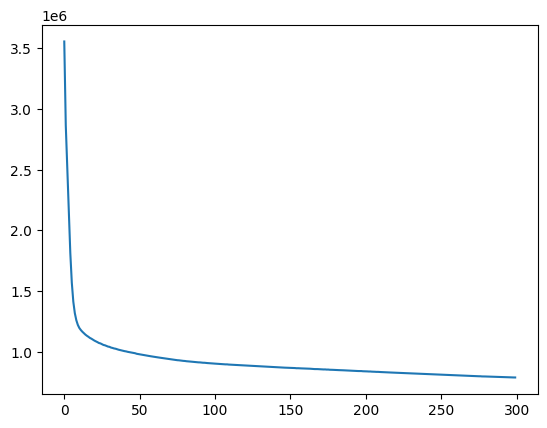

In [12]:
import matplotlib.pyplot as plt
plt.plot(trainLosses)